In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from torchvision import transforms
from PIL import Image

In [2]:
torch.cuda.empty_cache()

In [5]:
data1 = np.load('akshit_sum/data0.npy')
data2 = np.load('akshit_sum/data1.npy')
data3 = np.load('akshit_sum/data2.npy')
lab1 = np.load('akshit_sum/lab0.npy')
lab2 = np.load('akshit_sum/lab1.npy')
lab3 = np.load('akshit_sum/lab2.npy')

In [6]:
preprocess = transforms.Compose([
                transforms.Resize(55),                                                                                                                                        transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

In [7]:
X = np.concatenate((data1,data2,data3))

In [8]:
Y = np.concatenate((lab1,lab2,lab3))
train_x = X[:int(0.8*len(X))]
val_x = X[int(0.8*len(X)):]

train_y = Y[:int(0.8*len(Y))]
val_y = Y[int(0.8*len(Y)):]


In [9]:
del X,Y,data1,data2,data3,lab1,lab2,lab3

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)


num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 37) 

if torch.cuda.is_available():
  resnet.to('cuda')


Using cache found in /home/jashn.arora/.cache/torch/hub/pytorch_vision_v0.6.0


In [20]:
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True,patience=240)
if torch.cuda.is_available():
    loss = loss.cuda()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
def get_accuracy(pred,y):
    accu_sum=0
    for i in range(len(y)):
        maxi=-100000
        maxind=-1
        for j in range(37):
          # print(pred[i][j])
          if pred[i][j] >= maxi:
              maxind = j
              maxi=pred[i][j]
        if(maxind==y[i]):
            accu_sum+=1
        
    return accu_sum

In [22]:
index_list = np.arange(24000)
val_index_list = np.arange(6000)

train_losses= []
val_losses = []

train_accs = []
val_accs = []

batch_size = 100
cnt=-1
for epochs in range(100):
  acc_sum_ep_val = 0
  acc_sum_ep_trn = 0

  random.shuffle(index_list)
  for batch_no in range(int(len(train_x)/batch_size)):
    cnt+=1
    # print(index_list[batch_size*batch_no:batch_size*(batch_no+1)])
    train_batch_x = []
    
    for temp_img in train_x[index_list[batch_size*batch_no:batch_size*(batch_no+1)]]:
      PIL_image = Image.fromarray(np.uint8(temp_img)).convert('RGB')
      x1 = preprocess(PIL_image)
      train_batch_x.append(x1.numpy())
      # print(type(x1.numpy()))
    # train_batch_x = np.array(train_batch_x)
    
    # print(type(train_batch_x))
    train_batch_y = train_y[index_list[batch_size*batch_no:batch_size*(batch_no+1)]]

    train_batch_x = torch.tensor(train_batch_x)
    train_batch_y = torch.LongTensor(train_batch_y)

    if torch.cuda.is_available():
      train_batch_x = train_batch_x.cuda()
      train_batch_y = train_batch_y.cuda()
    resnet.train()
    output_train = resnet(train_batch_x.float())
    loss_train = loss(output_train, train_batch_y)
    train_losses.append(loss_train.item())
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if(cnt%1==0):
      random.shuffle(val_index_list)
      val_batch_x =[]
      for temp_img in val_x[val_index_list[:batch_size]]:
        PIL_image = Image.fromarray(np.uint8(temp_img)).convert('RGB')
        x1 = preprocess(PIL_image)
        val_batch_x.append(x1.numpy())
        # print(type(x1.numpy()))

      val_batch_y = val_y[val_index_list[:batch_size]]

      val_batch_x = torch.tensor(val_batch_x)
      val_batch_y = torch.LongTensor(val_batch_y)

      if torch.cuda.is_available():
        val_batch_x = val_batch_x.cuda()
        val_batch_y = val_batch_y.cuda()
    
      resnet.eval()
      output_val = resnet(val_batch_x.float())
      loss_val = loss(output_val, val_batch_y)
      val_losses.append(loss_val.item())
      scheduler.step(loss_val.item())
    else:
      val_losses.append(val_losses[-1])

    if(cnt%1==0):
      acc_tmp = get_accuracy(output_val.cpu().detach().numpy(),val_batch_y.cpu().detach().numpy())
      acc_sum_ep_val+=acc_tmp
      val_accs.append(acc_tmp/batch_size)
      acc_tmp = get_accuracy(output_train.cpu().detach().numpy(),train_batch_y.cpu().detach().numpy())
      acc_sum_ep_trn+=acc_tmp
      train_accs.append(acc_tmp/batch_size)

  for param_group in optimizer.param_groups:
        lr = param_group['lr']

  if(lr<0.0000001):
    break

  print("Epoch #",epochs,"Completed")
  print(train_losses[-1],val_losses[-1])
  print(acc_sum_ep_trn/len(train_x),acc_sum_ep_val/(batch_size*int(len(train_x)/batch_size)))
  # if(epochs>=5):
  #   inp = input()
  #   if(inp == "s"):
  #     break

Epoch # 0 Completed
1.926661491394043 2.0999884605407715
0.17316666666666666 0.12945833333333334
Epoch # 1 Completed
1.6779996156692505 1.9315930604934692
0.28983333333333333 0.21629166666666666
Epoch # 2 Completed
1.3691961765289307 1.7781236171722412
0.3700833333333333 0.325375
Epoch # 3 Completed
1.2056981325149536 1.5412417650222778
0.41508333333333336 0.38433333333333336
Epoch # 4 Completed
1.0885186195373535 1.3387640714645386
0.456 0.42504166666666665
Epoch # 5 Completed
1.0591917037963867 1.8219256401062012
0.47825 0.4895833333333333
Epoch # 6 Completed
1.092994213104248 1.0469317436218262
0.496125 0.4965
Epoch  1826: reducing learning rate of group 0 to 1.0000e-04.
Epoch # 7 Completed
0.6771163940429688 0.8026063442230225
0.5995 0.67825
Epoch # 8 Completed
0.7776451110839844 0.6394014954566956
0.6945 0.87125
Epoch # 9 Completed
0.5170651078224182 0.5760011076927185
0.7360416666666667 0.8722916666666667
Epoch # 10 Completed
0.621239185333252 0.6181690096855164
0.773583333333333

KeyboardInterrupt: 

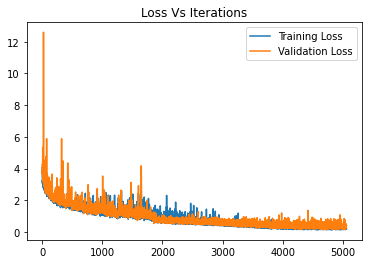

In [23]:
plt.plot(train_losses,label="Training Loss")
plt.plot(val_losses,label="Validation Loss")
plt.title("Loss Vs Iterations")
plt.legend()

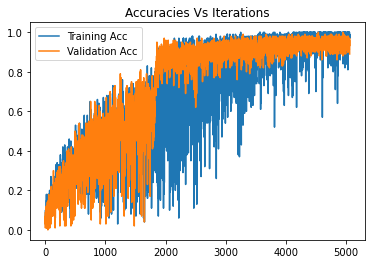

In [24]:
plt.plot(train_accs,label="Training Acc")
plt.plot(val_accs,label="Validation Acc")
plt.title("Accuracies Vs Iterations")
plt.legend()

In [25]:
# Accuracies

In [26]:
batch_size =50
correct_preds=0
resnet.eval()
for batch_no in range(int(len(train_x)/batch_size)):

    train_batch_x = []
    
    for temp_img in train_x[batch_size*batch_no:batch_size*(batch_no+1)]:
      PIL_image = Image.fromarray(np.uint8(temp_img)).convert('RGB')
      x1 = preprocess(PIL_image)
      train_batch_x.append(x1.numpy())
    
    train_batch_y = train_y[batch_size*batch_no:batch_size*(batch_no+1)]

    train_batch_x = torch.tensor(train_batch_x)
    train_batch_y = torch.LongTensor(train_batch_y)

    if torch.cuda.is_available():
      train_batch_x = train_batch_x.cuda()
      train_batch_y = train_batch_y.cuda()

    output_train = resnet(train_batch_x.cuda().float())
    correct_preds+=get_accuracy(output_train.cpu().detach().numpy(),train_batch_y.cpu().detach().numpy())
print("Overall Train Accuracy: ",100*correct_preds/len(train_x))

Overall Train Accuracy:  99.27916666666667


In [27]:
batch_size =50
correct_preds=0
resnet.eval()
for batch_no in range(int(len(val_x)/batch_size)):

    val_batch_x = []
    
    for temp_img in val_x[batch_size*batch_no:batch_size*(batch_no+1)]:
      PIL_image = Image.fromarray(np.uint8(temp_img)).convert('RGB')
      x1 = preprocess(PIL_image)
      val_batch_x.append(x1.numpy())
    
    val_batch_y = val_y[batch_size*batch_no:batch_size*(batch_no+1)]

    val_batch_x = torch.tensor(val_batch_x)
    val_batch_y = torch.LongTensor(val_batch_y)

    if torch.cuda.is_available():
      val_batch_x = val_batch_x.cuda()
      val_batch_y = val_batch_y.cuda()

    output_val = resnet(val_batch_x.cuda().float())
    correct_preds+=get_accuracy(output_val.cpu().detach().numpy(),val_batch_y.cpu().detach().numpy())
print("Overall Val Accuracy: ",100*correct_preds/len(val_x))

Overall Val Accuracy:  94.51666666666667


In [ ]:
#saving and loading the model

In [29]:
torch.save(resnet,"ResNet")

/home/jashn.arora/anaconda3/envs/tf-gpu-cuda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/jashn.arora/anaconda3/envs/tf-gpu-cuda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/jashn.arora/anaconda3/envs/tf-gpu-cuda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/jashn.arora/anaconda3/envs/tf-gpu-cuda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type R